<a href="https://colab.research.google.com/github/Yuji-207/Finance/blob/master/yahoo_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import json
import itertools
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
from bs4 import BeautifulSoup
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
path = '/content/drive/MyDrive/assets'
symbols = ['VT', 'BND', 'GLD']

In [ ]:
symbols = ['VT']
df1 = pd.read_csv(path + '/portfolios/VT.csv', names=symbols+['Return', 'Risk'])
symbols = ['VTI', 'VXUS']
df2 = pd.read_csv(path + '/portfolios/VTI_VXUS.csv', names=symbols+['Return', 'Risk'])
symbols = ['VOO', 'VXUS']
df3 = pd.read_csv(path + '/portfolios/VOO_VXUS.csv', names=symbols+['Return', 'Risk'])

In [ ]:
symbols = ['GLD', 'SLV']
df = pd.read_csv(path + '/portfolios/GLD_SLV.csv', names=symbols+['Return', 'Risk'])

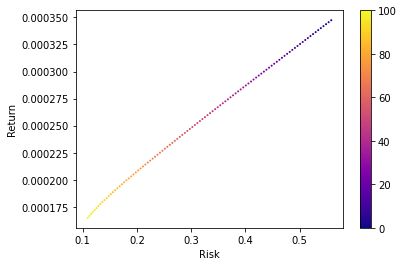

In [ ]:
# df = df[['SLV', 'Return', 'Risk']]
plt.figure(facecolor='white')
# plt.scatter(df1['Risk'], df1['Return'], s=1)
plt.scatter(df['Risk'], df['Return'], c=df['SLV'], cmap='plasma', s=1)
plt.colorbar()
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

In [ ]:
symbols = ['GLD', 'SLV']

for per in itertools.product(range(101), repeat=2):

    if sum(per) != 100:
        continue

    portfolio = PortFolio(symbols, per, path+'/historical data')
    returns = sum(portfolio.returns())
    risks = portfolio.risks()
    var = portfolio.var(risks)

    with open(path + '/portfolios/GLD_SLV.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(per + (returns, var))

    print(per)

(0, 100)
(1, 99)
(2, 98)
(3, 97)
(4, 96)
(5, 95)
(6, 94)
(7, 93)
(8, 92)
(9, 91)
(10, 90)
(11, 89)
(12, 88)
(13, 87)
(14, 86)
(15, 85)
(16, 84)
(17, 83)
(18, 82)
(19, 81)
(20, 80)
(21, 79)
(22, 78)
(23, 77)
(24, 76)
(25, 75)
(26, 74)
(27, 73)
(28, 72)
(29, 71)
(30, 70)
(31, 69)
(32, 68)
(33, 67)
(34, 66)
(35, 65)
(36, 64)
(37, 63)
(38, 62)
(39, 61)
(40, 60)
(41, 59)
(42, 58)
(43, 57)
(44, 56)
(45, 55)
(46, 54)
(47, 53)
(48, 52)
(49, 51)
(50, 50)
(51, 49)
(52, 48)
(53, 47)
(54, 46)
(55, 45)
(56, 44)
(57, 43)
(58, 42)
(59, 41)
(60, 40)
(61, 39)
(62, 38)
(63, 37)
(64, 36)
(65, 35)
(66, 34)
(67, 33)
(68, 32)
(69, 31)
(70, 30)
(71, 29)
(72, 28)
(73, 27)
(74, 26)
(75, 25)
(76, 24)
(77, 23)
(78, 22)
(79, 21)
(80, 20)
(81, 19)
(82, 18)
(83, 17)
(84, 16)
(85, 15)
(86, 14)
(87, 13)
(88, 12)
(89, 11)
(90, 10)
(91, 9)
(92, 8)
(93, 7)
(94, 6)
(95, 5)
(96, 4)
(97, 3)
(98, 2)
(99, 1)
(100, 0)


In [ ]:
symbols = ['GLD', 'SLV', 'PPLT']

for symbol in symbols:
    print(symbol)
    inst = Symbol(symbol)
    price, dividend = inst.history()
    price.to_csv(f'{path}/historical data/prices/{symbol}.csv')
    dividend.to_csv(f'{path}/historical data/dividends/{symbol}.csv')

GLD
SLV
PPLT


In [ ]:
class PortFolio:
 
 
    def __init__(self, symbols, per, path):
 
        per = np.array(per)
 
        if len(symbols) == len(per):
            if sum(per) == 100:
                self.symbols = symbols
                self.per = per / 100

            else:
                print('Sum of per is not 100.')
        else:
            print('Length of per is not same as number of symbols.')

        for symbol in symbols:

            price = pd.read_csv(f'{path}/prices/{symbol}.csv', usecols=['Date', 'Close*'])
            dividend = pd.read_csv(f'{path}/dividends/{symbol}.csv')
            
            price['Date'] = pd.to_datetime(price['Date'])
            dividend['Date'] = pd.to_datetime(dividend['Date'])
            price = price.set_index('Date')
            dividend = dividend.set_index('Date')

            price.columns = [symbol]
            dividend.columns = [symbol]

            if symbol == symbols[0]:
                prices = price
                dividends = dividend
            else:
                prices = prices.join(price, how='outer')
                dividends = dividends.join(dividend, how='outer')
 
        self.prices = prices
        self.dividends = dividends
        self.period_delta = prices.count()


    def returns(self):

        profits = np.prod(self.prices.pct_change() + 1)
        profits = profits ** (1 / self.period_delta) - 1
        profits = sum(profits * self.per)

        yields = (self.dividends / self.prices).sum()
        yields = yields / self.period_delta
        yields = sum(yields * self.per)

        return profits, yields

 
    def risks(self):
        profits, _ = self.returns()
        risks = (self.prices - profits).std()
        risks = risks / np.sqrt(self.period_delta)
        risks = risks * self.per
        return risks
 
 
    def var(self, vars):
 
        corr = self.prices.corr()
 
        vars = vars.values.reshape(1, -1)
        var = np.dot(vars, corr)
        var = np.dot(var, vars.T)
        var = np.sqrt(var.reshape(-1))
 
        return var[0]

In [ ]:
class Symbol:
 
 
    def __init__(self, symbol, output=False):
        self.url = 'https://finance.yahoo.com/quote/' + symbol
        self.symbol = symbol
        
        if output:
            print(self.url)
 
 
    def summary(self):
        dfs = pd.read_html(self.url, index_col=0)
        summary = pd.concat([dfs[0], dfs[1]])
        summary = summary.to_dict()[1]
        return summary
 
 
    def name(self):
        res = requests.get(self.url)
        soup = BeautifulSoup(res.content, 'html.parser')
        name = soup.find('h1').text
        return name
 
 
    def history(self, period_open=None, period_close=None, frequency='day', filter='history', include_adjusted_close='true'):
 
        if period_open:
            period_open = dt.datetime.strptime(period_open, '%Y-%m-%d')
        else:
            period_open = dt.datetime.strptime('1970-01-01', '%Y-%m-%d')
 
        if period_close:
            period_close = dt.datetime.strptime(period_close, '%Y-%m-%d')
        else:
            period_close = dt.datetime.now()
 
        period_delta = (period_close - period_open).days
        
        period_open = period_open.timestamp()
        period_close = period_close.timestamp()
        period_delta = dt.timedelta(days=101)
 
        periods_open = int(period_open)
        periods_close = int(period_close)
        periods_delta = int(period_delta.total_seconds())

        if frequency == 'day':
            interval = '1d'
            frequency = '1d'
 
        elif frequency == 'month':
            interval = '1mo'
            frequency = '1mo'
 
        for period1 in range(periods_open, periods_close, periods_delta):
 
            period1 = dt.timedelta(seconds=period1)
            period2 = period1 + dt.timedelta(days=100)
            period1 = str(int(period1.total_seconds()))
            period2 = str(int(period2.total_seconds()))
 
            url = self.url + '/history'
            url += '?period1=' + period1 + '&period2=' + period2 + '&interval=' + interval + '&filter=' + filter + '&frequency=' + frequency + '&includeAdjustedClose=' + include_adjusted_close
 
            if period1 == str(periods_open):
                history = pd.read_html(url)[0][:-1]
            else:
                history_add = pd.read_html(url)[0][:-1]
                history = pd.concat([history_add, history])
 
        history = history.replace(['-', '.* Stock Split'], np.nan, regex=True)
        history = history.dropna(how='any')
 
        history['Date'] = pd.to_datetime(history['Date'])
        history = history.set_index('Date')
        history = history[::-1]

        dividend = history['Open'].str.contains('Dividend')
        price = history[~dividend].astype(float)
        dividend = history[dividend]

        dividend = dividend['Open']
        dividend = dividend.str.replace(' Dividend', '')
        dividend = dividend.astype(float)
        dividend.name = 'Dividend'

        return price, dividend